In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import pandas as pd
import datetime as dt
import datetime
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)


In [6]:
# View all of the classes that automap found
class_names = sorted(Base.classes.keys())
class_names


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
print(f"({most_recent_date}),")


(2017-08-23),


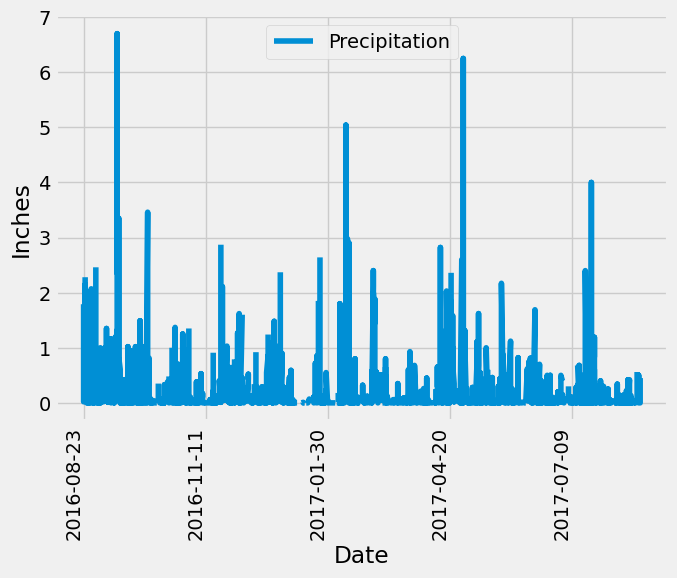

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago_from_last_date = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_from_last_date).all()

# Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

plt.figure(figsize=(7, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90, ha='right')  # Rotate labels by 90 degrees and align them
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set maximum number of ticks to 6
plt.legend(['Precipitation'], loc='upper center')
plt.tight_layout()
plt.show()


In [43]:
# Calculate summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Convert summary statistics to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics)

# Print the DataFrame
summary_statistics_df



,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [45]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations in the desired format
print(f"[({total_stations},)]")



[(9,)]


In [46]:
# Design a query to find the most active stations
most_active_stations_query = session.query(Measurement.station, func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()

# Print each station-count pair in the desired format
for i, (station, count) in enumerate(most_active_stations_query):
    if i == 0:
        print(f"[('{station}', {count}),")
    elif i == len(most_active_stations_query) - 1:
        print(f" ('{station}', {count})]")
    else:
        print(f" ('{station}', {count}),")


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [54]:

# Retrieve the most active station id
most_active_station = most_active_stations_query[0][0]

# Query to calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Print the calculated temperature statistics
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"[({lowest_temp}, {highest_temp}, {avg_temp})]")



[(54.0, 85.0, 71.66378066378067)]


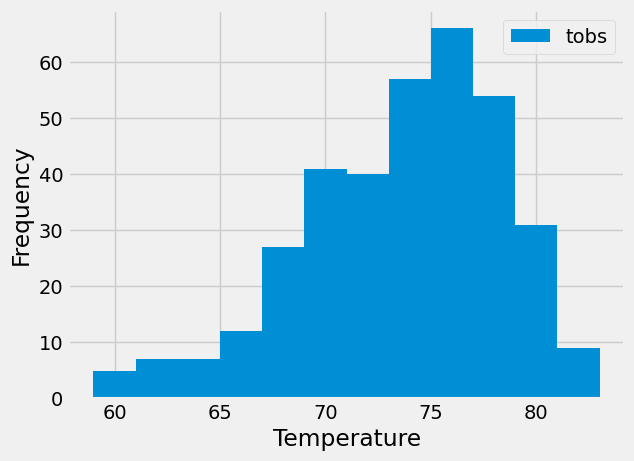

In [55]:

# Calculate the date 12 months ago from the last date in the dataset
last_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - timedelta(days=365)

# Query the temperature observations for the most active station in the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results into a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the histogram
plt.hist(temperature_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [56]:
# Close Session
session.close()